In [3]:
import scipy as sp
import numpy as np
import pandas as pd 
from IPython import display

# common model algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#common model helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#visiualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

import warnings 
warnings.filterwarnings('ignore')

import time
%matplotlib inline 
mpl.style.use('ggplot')
sns.set_style('white')  



# load data
#import training and test set
data_raw=pd.read_csv('train.csv')
data_val=pd.read_csv('test.csv')

#make a copy of the training set to wrangle 
data1=data_raw.copy(deep=True)

#put both in a list so we can clean both datasets at once
data_cleaner=[data1,data_val]

#get an overview of data
print(data_raw.info())
data1.head()
  

 
 


 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Get overview of data and missing values

#check for null values in training and test set
print('Training set null values\n',data1.isnull().sum())
print('-'*20)
print('test set null values\n',data_val.isnull().sum())
 


('Training set null values\n', PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64)
--------------------
('test set null values\n', PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64)


In [5]:
#test df null values : Age,Cabin and Embarked
#training df null values: Age,Fare,Cabin
#check for outliers /weird values
data_raw.describe(include='all')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Graham, Mr. George Edward",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Complete Data

Data to Complete
Age:Use median to complete missing values
Embarked:Use mode to complete missing values
Fare:Use median to complete missing fare

Data to Drop:
Cabin:Too many missing values, furthermore doesn't make sense to use this as a predictor to survival rate


In [6]:
#Complete Data for both training and test sets
for dataset in data_cleaner:
    dataset['Age'].fillna(value=dataset['Age'].median(), inplace=True)
    dataset['Embarked'].fillna(value=dataset['Embarked'].mode()[0], inplace=True)
    dataset['Fare'].fillna(value=dataset['Fare'].median(), inplace=True)
    

#data columns in test set
drop_columns =['PassengerId', 'Cabin', 'Ticket']
data1.drop(drop_columns, axis=1, inplace=True)

#check id data completed for both training and test set
print(data1.isnull().sum())
print('-'*20)
print(data_val.isnull().sum())
      

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


Create (Feature Engineering)

New Features To create
FamilySize: Parch+Sibsp+1
IsAlone:1 if alone else 0 if there are siblings
Title feature: Take out the titles from the names to see if people who have titles have higher chance of survival

Numerical Features that can be converted to categorial
FareBin: Cut Fare into 4 equal bins
AgeBin: Cut Age into 5 bins

In [7]:
#Create new features in both training and test set

for dataset in data_cleaner:
    #Create feature family size
    dataset['FamilySize']=dataset['Parch']+dataset['SibSp']+1
    
    #Create feature for IsAlone. for alone, 0 if there have siblings or children
    dataset['IsAlone']=1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    
    #Create Title feature
    dataset['Title']=dataset['Name'].str.split(', ', expand=True)[1].str.split('.',expand=True)[0] 
      
      
    # Create Age Bins
    dataset['AgeBin'] = pd.cut(dataset['Age'], 5)
    
    # Create Fare Bins
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
     
    

In [8]:
#Replace Wrong designations
data1['Title']=data1['Title'].replace({'Ms':'Miss', 'Mme':'Mrs', 'Mile':'Miss'})

#Group uncommon designations as misc
stat_min=10
title_names = data1['Title'].value_counts() <stat_min

data1['Title'] =data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x]==True else x)
print(data1['Title'].value_counts())


Mr        517
Miss      183
Mrs       126
Master     40
Misc       25
Name: Title, dtype: int64


# Convert Features:
 
 Convert text data to ordinal (LabelEncoder),then convert to    OneHot (pd.get_dummies)
 
Categorial Data: 
 
 Sex,Pclass,Emabarked,Title,SibSp,Parch,Age,Fare,FamilySize,IsAlone

In [9]:
data1.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,AgeBin,FareBin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(16.336, 32.252]","(-0.001, 7.91]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(32.252, 48.168]","(31.0, 512.329]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(16.336, 32.252]","(7.91, 14.454]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(32.252, 48.168]","(31.0, 512.329]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(32.252, 48.168]","(7.91, 14.454]"


In [10]:
#Code categorial data
label = LabelEncoder()

for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] =label.fit_transform(dataset['FareBin'])
    
 # define y variable for target/outcome
Target =['Survived']

# define x variable for original features aka feature selection
data1_x =['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
   

# pretty name/values for charts
data1_x_calc = ['Sex', 'Pclass', 'Embarked_Code', 'Title_Code', 'SibSp', 'Parch', 'Age', 'Fare' ] # coded for algo calc

data1_xy = Target + data1_x
print('Original X Y:',data1_xy,'\n')
 
 
# Define x variables for original with bin features. Categorial coded numerically instead of in words.
data1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y:', data1_xy_bin,'\n')


# Establish dummy variables
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y:', data1_xy_dummy,'\n')

data1_dummy.head()

    

('Original X Y:', ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'], '\n')
('Bin X Y:', ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'], '\n')
('Dummy X Y:', ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'], '\n')


,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [11]:
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
Name             418 non-null object
Sex              418 non-null object
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
Ticket           418 non-null object
Fare             418 non-null float64
Cabin            91 non-null object
Embarked         418 non-null object
FamilySize       418 non-null int64
IsAlone          418 non-null int64
Title            418 non-null object
AgeBin           418 non-null category
FareBin          418 non-null category
Sex_Code         418 non-null int32
Embarked_Code    418 non-null int32
Title_Code       418 non-null int32
AgeBin_Code      418 non-null int32
FareBin_Code     418 non-null int32
dtypes: category(2), float64(2), int32(5), int64(6), object(6)
memory usage: 54.9+ KB


# Split data into training and test set

In [12]:
# Split data into training and test set
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state=0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target], random_state=0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy],data1[Target], random_state=0)

print('Data1 Shape:', data1.shape)
print('Train1 Shape:', train1_x.shape)
print('Test1 Shape:', test1_x.shape)

train1_x_bin.head()

('Data1 Shape:', (891, 19))
('Train1 Shape:', (668, 8))
('Test1 Shape:', (223, 8))


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


# Perform exploratory analysis with statistics

Create a pivot table to observe each predictor's correlation with the Tarhet (survival)

In [13]:
# Discrete varaible correlation by survival using gropuby pivot table
for x in data1_x:
    if data1[x].dtype != 'float64':
        print('Survial Correlation by: ', x)
        print(data1[[x,Target[0]]].groupby(by=x, as_index=False).mean())
        print('-'*40, '\n')
        
# using crosstabs
print(pd.crosstab(data1['Title'], data1[Target[0]]))


('Survial Correlation by: ', 'Sex')
      Sex  Survived
0  female  0.742038
1    male  0.188908
('----------------------------------------', '\n')
('Survial Correlation by: ', 'Pclass')
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
('----------------------------------------', '\n')
('Survial Correlation by: ', 'Embarked')
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
('----------------------------------------', '\n')
('Survial Correlation by: ', 'Title')
    Title  Survived
0  Master  0.575000
1    Misc  0.400000
2    Miss  0.699454
3      Mr  0.156673
4     Mrs  0.793651
('----------------------------------------', '\n')
('Survial Correlation by: ', 'SibSp')
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
('----------------------------------------', '\n')
('Survial Correlation by: ', 'Parch')
   Parch  Survived


# Plot numerical continous variables

Look at distribution of numerical continous variables

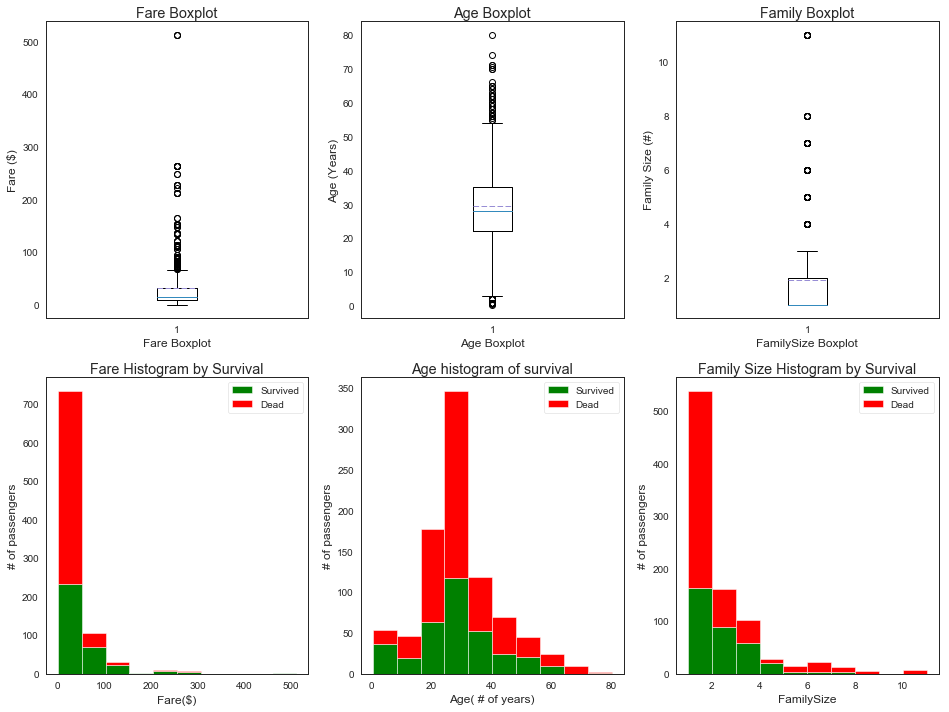

In [14]:
plt.figure(figsize=(16,12))
0
plt.subplot(231)
plt.boxplot(data1['Fare'], meanline =True, showmeans=True);
plt.xlabel('Fare Boxplot')
plt.ylabel('Fare ($)')
plt.title('Fare Boxplot')

plt.subplot(232)
plt.boxplot(data1['Age'], meanline=True, showmeans=True); 
plt.xlabel('Age Boxplot')
plt.ylabel('Age (Years)')
plt.title('Age Boxplot')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], meanline=True, showmeans=True);
plt.xlabel('FamilySize Boxplot')
plt.ylabel('Family Size (#)')
plt.title('Family Boxplot')

plt.subplot(234)
plt.hist(x=[data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']],stacked=True, color=['g','r'], label=['Survived', 'Dead'])
plt.xlabel('Fare($)')
plt.ylabel('# of passengers')
plt.title('Fare Histogram by Survival')
plt.legend()                                     


plt.subplot(235)
plt.hist(x=[data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']],
         stacked=True, color=['g','r'], label=['Survived', 'Dead'])
plt.xlabel('Age( # of years)')
plt.ylabel('# of passengers')
plt.title('Age histogram of survival')
plt.legend()   
                                               

plt.subplot(236)
plt.hist(x=[data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']],stacked=True, color=['g','r'], label=['Survived', 'Dead'])
plt.xlabel('FamilySize')
plt.ylabel('# of passengers')
plt.title('Family Size Histogram by Survival')
plt.legend()                                                  

# Plot categorical features

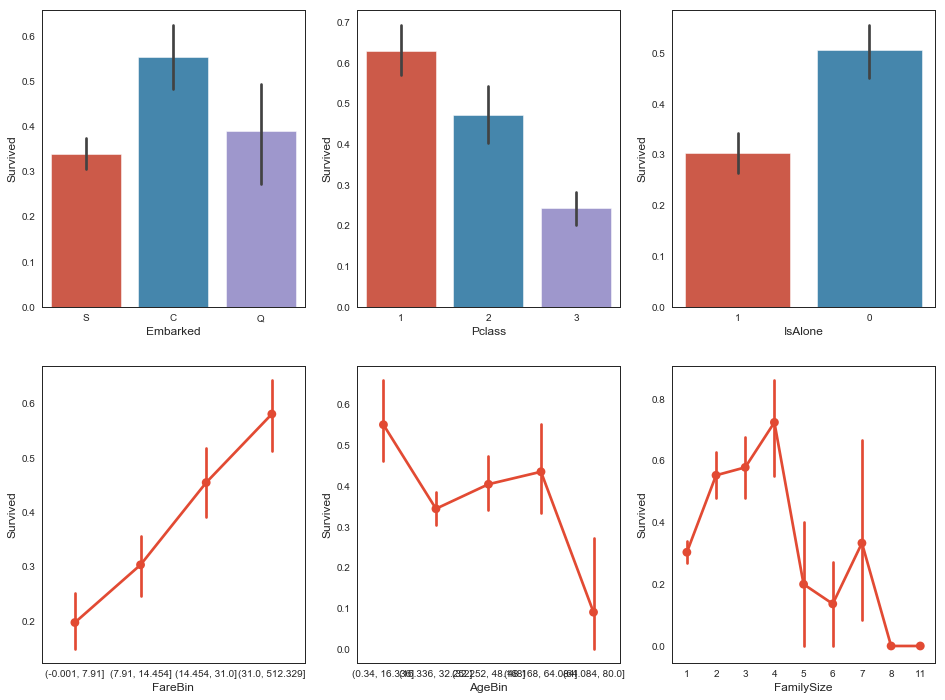

In [15]:
fig, saxis = plt.subplots(2,3,figsize=(16,12))

sns.barplot(x='Embarked', y= 'Survived', data=data1, ax=saxis[0,0])
sns.barplot(x= 'Pclass', y='Survived', data=data1, ax=saxis[0,1])
sns.barplot(x='IsAlone', y='Survived', data=data1, ax=saxis[0,2], order=[1,0])


sns.pointplot(x='FareBin', y='Survived', data=data1, ax=saxis[1,0])
sns.pointplot(x='AgeBin', y='Survived', data=data1, ax=saxis[1,1])
sns.pointplot(x='FamilySize', y='Survived', data=data1, ax=saxis[1,2])

. Passenger from port C had a significantly higher chance of survival 
.May be multicollinearity ,where passengers who had higher fare/ class boarding from port c
.Passengers from better class have higher chance of survival 
.Passengers who were not alone had a higher chance of survival 
.Passengers who paid higher fares had higher chance of survival .
Again,may be multicollinearity between fare and Pclass


# Graph distribution Pclass w.r.t other variables (Fare,Age,Family Size)

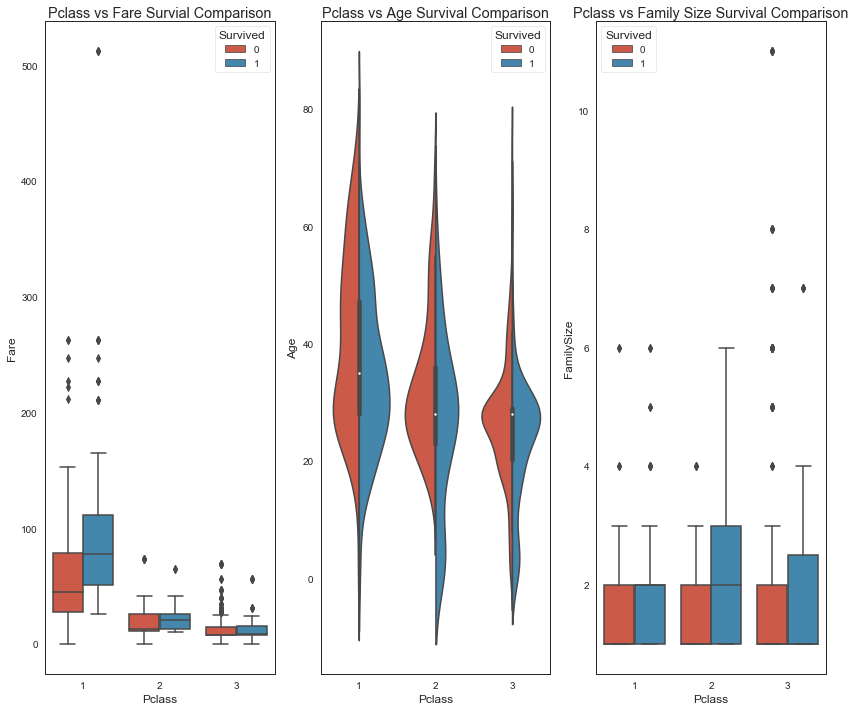

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,12))

sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=data1, ax=ax1)
ax1.set_title('Pclass vs Fare Survial Comparison')

sns.violinplot(x='Pclass', y='Age', hue='Survived', data=data1,ax=ax2, split=True)
ax2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x='Pclass', y='FamilySize', hue='Survived', data=data1, ax=ax3)
ax3.set_title('Pclass vs Family Size Survival Comparison')

. Passengers from higher classes paid a higher fare
. Passengers who are older tend to be from higher classes
. No clear relationship between FamilySize and Pclass

# Graph distribution of sex variables

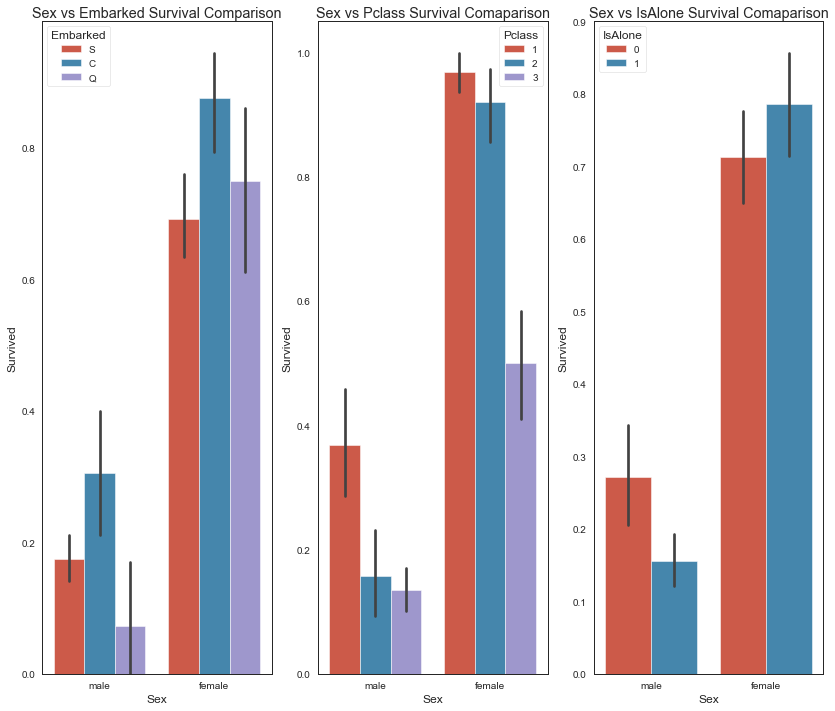

In [17]:
# graph distribution of qualitative data:sex

fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x= 'Sex', y='Survived', hue = 'Embarked', data=data1, ax=qaxis[0])
qaxis[0].set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x= 'Sex', y='Survived', hue ='Pclass', data=data1,ax=qaxis[1])
qaxis[1].set_title('Sex vs Pclass Survival Comaparison')

sns.barplot(x= 'Sex', y='Survived', hue ='IsAlone', data=data1,ax=qaxis[2])
qaxis[2].set_title('Sex vs IsAlone Survival Comaparison')


obvious that females had a much higher chance of survival than males

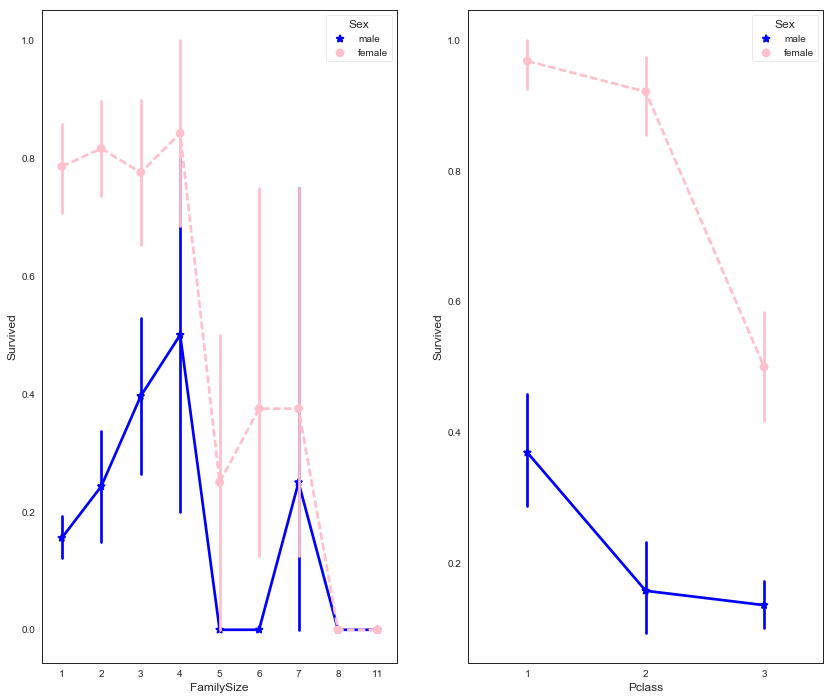

In [18]:
# more side by side comparisons of FamilySize and Pclass vs thw dependent variables

fig, (maxis1, maxis2) = plt.subplots(1,2,figsize=(14,12))

# family size with survival and sex compare
sns.pointplot(x='FamilySize', y='Survived', hue='Sex', data=data1, ax=maxis1, palette={'male':'blue','female':'pink'},markers=['*','o'], linestyles=['-','--'])

# pclass with survival and sex compare
sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=data1, ax=maxis2, palette={'male':'blue','female':'pink'},markers=['*','o'], linestyles=['-','--'])

.Again clear that females have higher chance of survival
. No clear relationship between FamilySize and Survival 
. Clear relationship between Pclass and Survival 

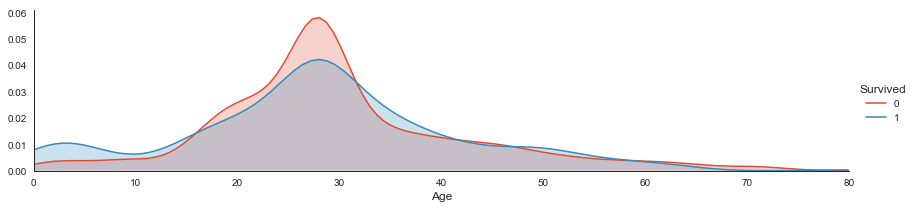

In [19]:
# plot distribution of passengers who survived vs died
a= sns.FacetGrid(data1, hue='Survived', aspect=4)
a.map(sns.kdeplot, 'Age', shade=True)
a.set(xlim=(0,data1['Age'].max()))
a.add_legend()


.Higher proportion of young children (below 15) survived -More survived than died
.Lower proportion of middle aged (20-35) survived -More died than survived 
.Above 35,about equal percentages survived and died

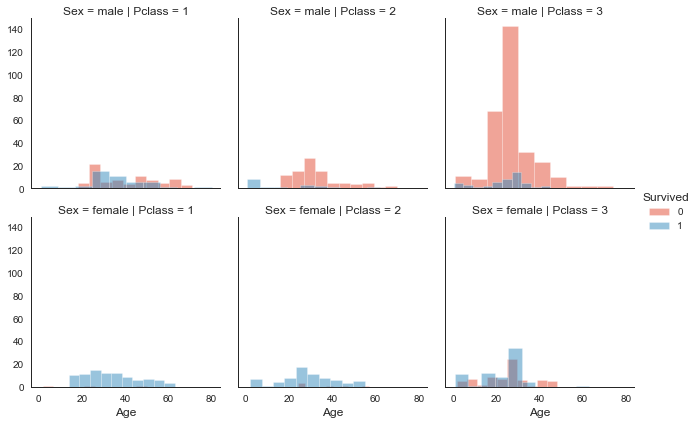

In [20]:
# Comparison of Sex,Class and Age

s=sns.FacetGrid(data1, row='Sex', col='Pclass', hue='Survived')
s.map(plt.hist, 'Age', alpha=0.5)
s.add_legend()

. We can see that the vast proportion of those who died are males from 2nd and 3rd class
. Almost all females from the 1st and 2nd class survived


In [21]:
# correlation heatmap of dataset
def correlation_heatmap(df):
    _ ,ax = plt.subplts(figsize=(14,12))
    colormap = sns.diverging_palette(220,10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square=True,
        cbar_kws={'shrink':.9},
        ax=ax,
        annot=True,
        linewidth=0.1,vmax=1.0, linecolor='white',
        annot_kws={'frontsize':12}
    )
    plt.title('Pearson Correlation of features', y=1.05, size=15)
    
    correlation_heatmap(data1)

.Corr heatmaps shows the followings:

.Strong negative correlation between Pclass and FareBin (higher fare ,lower the class)
.Strong negative correlation between FareBin_Code and IsAlone
.As noted earlier ,strong correlation between Sex and Survived
.As noted earlier,moderate negative correlation between Pclass and Survived
.Moderate positive correlation between Tilte and Age.Makes sense

Of course ,strong correlation between the below features as they were engineered:


# -SibSp and Parch and the additional features that we derived from them :Family Size and IsAlone

# Model Data

##Create a table with all the base models ,evaluating the CV train and test accuracy ,as well as the standard deviation

In [22]:
# Machine Learning Algo Selection and Initialization 
MLA = [
    #Ensemble methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    # Gaussian Process
    gaussian_process.GaussianProcessClassifier(),
    
    # General Linear models
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbour
    neighbors.KNeighborsClassifier(),
    
    
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    
    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Descriminant Analysis 
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # XGBoost
    XGBClassifier()
    
    
]

Implementing alogorithms ...Cross validation accuracy

In [75]:
index_names=['AdaBoostClassifier',
    'BaggingClassifier',
    'ExtraTreesClassifier',
    'GradientBoostingClassifier',
    'RandomForestClassifier',
    
    # Gaussian Process
    'GaussianProcessClassifier',
    
    # General Linear models
    'LogisticRegressionCV',
    'PassiveAggressiveClassifier',
    'RidgeClassifierCV',
    'SGDClassifier',
    'Perceptron',
    
    # Naive Bayes
    'BernoulliNB',
    'GaussianNB',
    
    # Nearest Neighbour
    'KNeighborsClassifier',
    
    
    # SVM
    'svm.SVC',
    'svm.NuSVC',
    
    # Trees
    'DecisionTreeClassifier',
    'ExtraTreeClassifier',
    
    # Descriminant Analysis 
    'LinearDiscriminantAnalysis',
    'QuadraticDiscriminantAnalysis',
    
    # XGBoost
    'XGBClassifier'
]
dataframe=[]
dataframe_cv=[]
accuracy_CV=[]

for i in range(len(MLA)):
    model=MLA[i].fit(train1_x_bin,train1_y_bin)
    test1_y_pred=model.predict(test1_x_bin)
    test=model.predict(data_val[data1_x_bin])
    accuracy_CV.append(metrics.accuracy_score(test1_y_bin,test1_y_pred))
    dataframe_cv.append(test1_y_pred)
    dataframe.append(test)
acc=pd.DataFrame(accuracy_CV)
acc.index=index_names
acc.columns=['Accuracy_CV']
out=pd.DataFrame(dataframe)
out_cv=pd.DataFrame(dataframe_cv)
out.index=index_names
print(acc)
 

                               Accuracy_CV
AdaBoostClassifier                0.829596
BaggingClassifier                 0.843049
ExtraTreesClassifier              0.829596
GradientBoostingClassifier        0.825112
RandomForestClassifier            0.820628
GaussianProcessClassifier         0.820628
LogisticRegressionCV              0.802691
PassiveAggressiveClassifier       0.376682
RidgeClassifierCV                 0.789238
SGDClassifier                     0.376682
Perceptron                        0.484305
BernoulliNB                       0.784753
GaussianNB                        0.789238
KNeighborsClassifier              0.811659
svm.SVC                           0.816143
svm.NuSVC                         0.816143
DecisionTreeClassifier            0.825112
ExtraTreeClassifier               0.820628
LinearDiscriminantAnalysis        0.789238
QuadraticDiscriminantAnalysis     0.802691
XGBClassifier                     0.829596


In [67]:
out_cv.T.std()

0     0.491720
1     0.476533
2     0.465121
3     0.463293
4     0.475047
5     0.485644
6     0.485644
7     0.501120
8     0.482012
9     0.484478
10    0.384527
11    0.485644
12    0.499667
13    0.485644
14    0.484478
15    0.484478
16    0.459484
17    0.471933
18    0.482012
19    0.496259
20    0.461415
dtype: float64

Standard_deviation

In [68]:
out.T.std()

AdaBoostClassifier               0.495062
BaggingClassifier                0.488858
ExtraTreesClassifier             0.494320
GradientBoostingClassifier       0.480238
RandomForestClassifier           0.487777
GaussianProcessClassifier        0.448308
LogisticRegressionCV             0.440875
PassiveAggressiveClassifier      0.466329
RidgeClassifierCV                0.454062
SGDClassifier                    0.464430
Perceptron                       0.496710
BernoulliNB                      0.464430
GaussianNB                       0.455166
KNeighborsClassifier             0.477315
svm.SVC                          0.496710
svm.NuSVC                        0.498302
DecisionTreeClassifier           0.467257
ExtraTreeClassifier              0.494320
LinearDiscriminantAnalysis       0.456255
QuadraticDiscriminantAnalysis    0.465387
XGBClassifier                    0.476551
dtype: float64

In [93]:
out.iloc[1,0:].to_csv("output_machine_larning.csv")
 

# Implementing Neural Network

In [ ]:
from numpy import *
  
class NeuralNet(object): 
    def __init__(self): 
        # Generate random numbers 
        random.seed(1) 
  
        # Assign random weights to a 3 x 1 matrix, 
        self.synaptic_weights = 2 * random.random((3, 1)) - 1
  
    # The Sigmoid function 
    def __sigmoid(self, x): 
        return 1 / (1 + exp(-x)) 
  
    # The derivative of the Sigmoid function. 
    # This is the gradient of the Sigmoid curve. 
    def __sigmoid_derivative(self, x): 
        return x * (1 - x) 
  
    # Train the neural network and adjust the weights each time. 
    def train(self, inputs, outputs, training_iterations): 
        for iteration in xrange(training_iterations): 
  
            # Pass the training set through the network. 
            output = self.learn(inputs) 
  
            # Calculate the error 
            error = outputs - output 
  
            # Adjust the weights by a factor 
            factor = dot(inputs.T, error * self.__sigmoid_derivative(output)) 
            self.synaptic_weights += factor 
  
    # The neural network thinks. 
    def learn(self, inputs): 
        return self.__sigmoid(dot(inputs, self.synaptic_weights)) 
  
if __name__ == "__main__": 
  
    #Initialize 
    neural_network = NeuralNet() 
  
    # The training set. 
    inputs = array([[0, 1, 1], [1, 0, 0], [1, 0, 1]]) 
    outputs = array([[1, 0, 1]]).T 
  
    # Train the neural network 
    neural_network.train(inputs, outputs, 10000) 
  
    # Test the neural network with a test example. 
    print neural_network.learn(array([1, 0, 1])) 

# Implementing on dummy data(additional variable) that was created

In [86]:
dataframe1=[]
dataframe1_cv=[]
accuracy1_CV=[]

for i in range(len(MLA)):
    model=MLA[i].fit(train1_x_dummy,train1_y_dummy) 
    test1_y_dummy_pred=model.predict(test1_x_dummy)
    test1=model.predict(data1_dummy[data1_x_dummy])
    accuracy1_CV.append(metrics.accuracy_score(test1_y_dummy,test1_y_dummy_pred))
    dataframe1_cv.append(test1_y_dummy_pred)
    dataframe1.append(test1)
acc1=pd.DataFrame(accuracy1_CV)
acc1.index=index_names
acc1.columns=['Accuracy_CV']
out1=pd.DataFrame(dataframe1)
out1_cv=pd.DataFrame(dataframe1_cv)
out1.index=index_names
print(acc1)
 

                               Accuracy_CV
AdaBoostClassifier                0.793722
BaggingClassifier                 0.820628
ExtraTreesClassifier              0.793722
GradientBoostingClassifier        0.856502
RandomForestClassifier            0.838565
GaussianProcessClassifier         0.748879
LogisticRegressionCV              0.811659
PassiveAggressiveClassifier       0.672646
RidgeClassifierCV                 0.816143
SGDClassifier                     0.587444
Perceptron                        0.614350
BernoulliNB                       0.784753
GaussianNB                        0.766816
KNeighborsClassifier              0.762332
svm.SVC                           0.744395
svm.NuSVC                         0.753363
DecisionTreeClassifier            0.789238
ExtraTreeClassifier               0.798206
LinearDiscriminantAnalysis        0.820628
QuadraticDiscriminantAnalysis     0.618834
XGBClassifier                     0.843049


In [76]:
out1_cv.T.std()

0     0.489868
1     0.470303
2     0.489868
3     0.471933
4     0.471933
5     0.471933
6     0.489868
7     0.498898
8     0.484478
9     0.000000
10    0.094489
11    0.491720
12    0.497438
13    0.482012
14    0.492582
15    0.494179
16    0.486766
17    0.484478
18    0.483267
19    0.115463
20    0.473514
dtype: float64

In [77]:
out1.T.std()

AdaBoostClassifier               0.484359
BaggingClassifier                0.480996
ExtraTreesClassifier             0.485217
GradientBoostingClassifier       0.476219
RandomForestClassifier           0.481633
GaussianProcessClassifier        0.475122
LogisticRegressionCV             0.481633
PassiveAggressiveClassifier      0.496383
RidgeClassifierCV                0.478336
SGDClassifier                    0.000000
Perceptron                       0.047351
BernoulliNB                      0.488896
GaussianNB                       0.491199
KNeighborsClassifier             0.478336
svm.SVC                          0.484647
svm.NuSVC                        0.486592
DecisionTreeClassifier           0.484359
ExtraTreeClassifier              0.483772
LinearDiscriminantAnalysis       0.477990
QuadraticDiscriminantAnalysis    0.132871
XGBClassifier                    0.476936
dtype: float64

In [78]:
 out1.head()

,0,1,2,3,4,5,6,7,8,9,...,881,882,883,884,885,886,887,888,889,890
AdaBoostClassifier,0,1,1,1,0,0,0,0,1,1,...,0,1,0,0,0,0,1,0,0,0
BaggingClassifier,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
ExtraTreesClassifier,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
GradientBoostingClassifier,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
RandomForestClassifier,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0


# on_original_dataset

In [87]:
dataframe2=[]
dataframe2_cv=[]
accuracy2_CV=[]

for i in range(len(MLA)):
    model=MLA[i].fit(train1_x_bin,train1_y_bin)
    test2_y_pred=model.predict(test1_x)
    test2=model.predict(data_val[data1_x])
    accuracy2_CV.append(metrics.accuracy_score(test1_y,test2_y_pred))
    dataframe2_cv.append(test2_y_pred)
    dataframe2.append(test2)
acc2=pd.DataFrame(accuracy2_CV)
acc2.index=index_names
acc2.columns=['Accuracy_CV']
out2=pd.DataFrame(dataframe2)
out2_cv=pd.DataFrame(dataframe2_cv)
out2.index=index_names
print(acc)
 

ValueError: could not convert string to float: female